## ML Project: K-Means Clustering Method

Instructions & Overview
* To get the outputs in our presentation and report regarding K-Means Clustering, run all the code cells below
* The code is titled by section for organization and convenience

## 1) Setup

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
import itertools

C:\Users\simon\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\simon\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\simon\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [3]:
# reading in COVID-19 datasets
# Link to Datasets: https://covid19.who.int/data)
dem_df_raw = pd.read_csv('../data/demographics.csv')
eco_df_raw = pd.read_csv('../data/economy.csv')
epi_df_raw = pd.read_csv('../data/epidemiology.csv')
vac_df_raw = pd.read_csv('../data/vaccinations.csv')
hos_df_raw = pd.read_csv('../data/hospitalizations.csv')
gov_df_raw = pd.read_csv('../data/oxford-government-response.csv')
idx_df_raw = pd.read_csv('../data/index.csv')

## 2) K Means Clustering Code (for clustering analysis)

In [4]:
# get_distance: gets the distance between a data point and a mean
# inputs: data point and mean centroid
# output: the distance
def get_distance(data_row, k_row):
    sum = 0
    for i in range(len(data_row)): #208
        sum += ((data_row[i] - k_row[i]) ** 2)
    dist = sum ** 0.5
    return dist

# generate_clusters: labels every covid data point with the cluster they belong to
# inputs: covid data and test means data
# output: list of cluster labels for each covid data point
def generate_clusters(covid_data, test_means, k):
    cluster_ids = []
    objective = 0.0
    # go through all data points
    for d_row in range(len(covid_data)):
        dists = []
        # compare the distances between data point and each of the k centroids
        for k_row in range(k):
            dist = get_distance(covid_data[d_row], test_means[k_row])
            dists.append(dist)            
        # assign data point to closest mean (centroid)
        min_dist = np.min(dists)
        objective += min_dist
        cluster_ids.append(np.where(dists == min_dist)[0][0])
    return cluster_ids

# update_means: updates the positions of the centroids
# inputs: cluster labels and covid data
# output: the new positions of the mean centroids
def update_means(cluster_ids, covid_data, k):
    new_means = np.zeros((k, covid_data.shape[1]))
    # range through the data and take the mean, column by column,
    # by data point rows that are in the same cluster
    for j in range(covid_data.shape[1]):
        for k_num in range(k):
            curr_list = []
            for i in range(len(cluster_ids)):
                if cluster_ids[i] == k_num:
                    curr_list.append(covid_data[i][j])
            if len(curr_list) > 0:
                new_means[k_num][j] = np.mean(curr_list)
    return new_means

# get_objective: computes the objective value from the data, given the current centroid positions
# inputs: covid data, updated centroid means, cluster labels for each data point
# output: the objective value
def get_objective(covid_data, means, cluster_ids, k):
    objective = 0
    # compute objective (add up all intracluster distances, then add up those sums for each cluster)
    for k_num in range(k):
        intra_cluster_sum = 0
        for i in range(len(cluster_ids)): # 879
            if cluster_ids[i] == k_num:
                intra_cluster_sum += (get_distance(means[k_num], covid_data[i]) ** 2)
        objective += intra_cluster_sum
    return objective

# run_k_means: run the k-means algorithm (repeatedly generating clusters and updating means
#              until centroids do not change or max iterations reached)
# inputs: covid data and initial means
# output: cluster labels, updated means, updated objective values
def run_k_means(covid_data, test_means, k):
    means = test_means
    count = 0
    objectives = []
    prev_cluster_ids = []
    # keep running k means until a stopping condition is meant
    while(True):
        count += 1
        # generate clusters
        cluster_ids = generate_clusters(covid_data, means, k)
        # update means
        means = update_means(cluster_ids, covid_data, k)
        # compute and track objective score
        objective = get_objective(covid_data, means, cluster_ids, k)
        objectives.append(objective)
        # stopping condition: all points remain in the same cluster
        if cluster_ids == prev_cluster_ids:
            #print("BREAK: points remain in same cluster")
            break;
        # track previous cluster labels for stopping condition
        prev_cluster_ids = cluster_ids
        # stopping condition: max iterations reached
        if count == 50:
            #print("BREAK: max iteration reached")
            break   
    return cluster_ids, means, objectives

## 3) Data Processing

In [5]:
# get copies of raw datasets
dem_df = dem_df_raw
eco_df = eco_df_raw
epi_df = epi_df_raw
vac_df = vac_df_raw
hos_df = hos_df_raw
gov_df = gov_df_raw
idx_df = idx_df_raw

In [6]:
# select_country_for_dfs: Extracts specified rows of datasets based on given country
def select_country_for_dfs(gov_df, epi_df, vac_df, hos_df, country):
    gov_df['location_key'] = gov_df['location_key'].str.slice(0,2)
    gov_df = gov_df.loc[gov_df['location_key'] == country]
    gov_df_agg = gov_df.groupby(['location_key', 'date']).mean()
    #gov_day_agg
    epi_df['location_key'] = epi_df['location_key'].str.slice(0,2)
    epi_df = epi_df.loc[epi_df['location_key'] == country]
    epi_df_agg = epi_df.groupby(['location_key', 'date']).sum()
    #epi_day_agg
    vac_df['location_key'] = vac_df['location_key'].str.slice(0,2)
    vac_df = vac_df.loc[vac_df['location_key'] == country]
    vac_df_agg = vac_df.groupby(['location_key', 'date']).sum()
    #vac_day_agg
    hos_df['location_key'] = hos_df['location_key'].str.slice(0,2)
    hos_df = hos_df.loc[hos_df['location_key'] == country]
    hos_df_agg = hos_df.groupby(['location_key', 'date']).sum()
    
    return gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg

In [7]:
# merge_dfs: merge the datasets together
def merge_dfs(gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg):
    covid_merged_df = epi_df_agg.merge(vac_df_agg.merge(hos_df_agg.merge(gov_df_agg, on='date', how='outer'), on='date', how='outer'), on='date', how='outer')
    return covid_merged_df

In [8]:
# generate_norm_df: generates normalized covid data from the merged covid data and the given list of factors
def generate_norm_df(covid_merged_df, factors_list):
    covid_merged_mini_df = covid_merged_df[factors_list]
    #covid_norm_df = (covid_merged_mini_df-covid_merged_mini_df.mean())/((len(factors_list) ** 0.5) * covid_merged_mini_df.std())
    if len(factors_list) > 1:
        covid_norm_df = (covid_merged_mini_df-covid_merged_mini_df.mean())/(covid_merged_mini_df.std())
        for i in range(covid_norm_df.shape[0]):
            dist = 0
            for j in range(covid_norm_df.shape[1]):
                dist += covid_norm_df.iloc[i][j] ** 2
            dist = dist ** 0.5
            for j in range(covid_norm_df.shape[1]):
                covid_norm_df.iloc[i][j] = (covid_norm_df.iloc[i][j]) / dist
    else:
        col_sum = np.mean(covid_merged_df[factors_list])
        covid_norm_df = covid_merged_mini_df / col_sum
        #covid_norm_df = (covid_merged_mini_df-covid_merged_mini_df.mean())/(covid_merged_mini_df.std())
    return covid_norm_df

In [9]:
# variable declarations
country = 'US'
factors_list = ['new_confirmed', 'new_deceased', 'new_persons_vaccinated', 'new_persons_fully_vaccinated', 'new_hospitalized_patients', 'new_intensive_care_patients']

# getting the merged prediction and true data frames for covid cases
gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg = select_country_for_dfs(gov_df, epi_df, vac_df, hos_df, country)
covid_merged_df = merge_dfs(gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg)
covid_norm_pred_df = generate_norm_df(covid_merged_df, factors_list)
covid_norm_pred_df_nonan = covid_norm_pred_df.dropna(axis=0, how='any')
covid_norm_pred_df_nonan.head()

,new_confirmed,new_deceased,new_persons_vaccinated,new_persons_fully_vaccinated,new_hospitalized_patients,new_intensive_care_patients
date,,,,,,
2020-12-13,0.328308,0.305136,-0.375722,-0.195483,0.763440,0.192055
2020-12-14,0.272652,0.227118,-0.274551,-0.138148,0.552426,0.688797
2020-12-15,0.191970,0.457072,-0.179030,-0.094959,0.506277,0.675905
2020-12-16,0.240716,0.546469,-0.139788,-0.086504,0.432919,0.654970
2020-12-17,0.260283,0.564695,-0.125769,-0.093933,0.455605,0.617377


## 4) Making the Objective Elbow Plot

In [10]:
# making the elbow plot
covid_mtx = covid_norm_pred_df_nonan.to_numpy()
ks = []
last_objs = []
for i in range(2, 15):
    k = i
    print('k:', k)
    rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
    k_means_results = run_k_means(covid_mtx, rand_means, k)
    clusters, means, objectives = k_means_results
    best_obj = objectives[len(objectives)-1]
    for trial in range(19):
        rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
        k_means_results = run_k_means(covid_mtx, rand_means, k)
        clusters, means, objectives = k_means_results
        curr_obj = objectives[len(objectives)-1]
        if curr_obj < best_obj:
            best_obj = curr_obj
    ks.append(k)
    last_objs.append(best_obj)

k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14


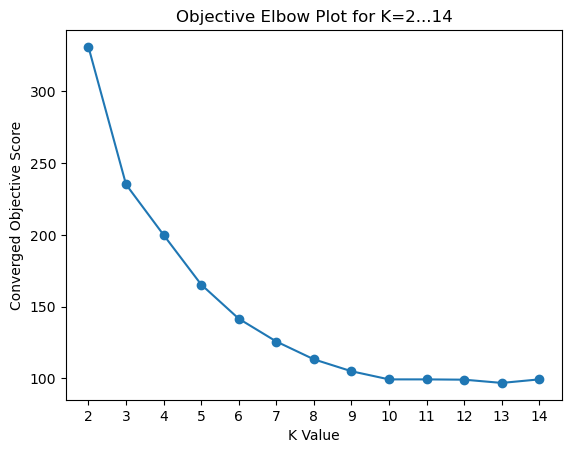

In [11]:
# make objective elbow plot
plt.scatter(ks, last_objs)
plt.xlabel('K Value')
plt.ylabel('Converged Objective Score')
plt.title('Objective Elbow Plot for K=2...14')
plt.xticks(range(2, 15))
plt.plot(ks, last_objs)

## 5) Training and Testing for K=3 Clustering

In [12]:
# get_cluster_pred_df: computes cluster ID predictions for new cases based on proxy factors in covid data
# inputs:the normalized COVID data containing the main features, k-value
# output: the k-means results
def train_k_means(covid_norm_pred_df_nonan, k):
    # convert data frame to matrix form for k-means
    covid_mtx = covid_norm_pred_df_nonan.to_numpy()

    # run k-means
    rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
    k_means_results = run_k_means(covid_mtx, rand_means, k)
    
    return k_means_results

In [13]:
# run_one_train_test: trains k-means model on a given proportion of the whole data, 
#                     also uses the trained centroids to get the objective for the remaining test data
# inputs: the covid dataset, the proportion of data that is train data, k value
# outputs: the train and test final objectives
def run_one_train_test(covid_norm_pred_df_nonan, train_prop, k):
    train_size = round(covid_norm_pred_df_nonan.shape[0] * train_prop)
    train_results = train_k_means(covid_norm_pred_df_nonan[:train_size], k)
    train_objs = train_results[2]
    test_mtx = covid_norm_pred_df_nonan[train_size:].to_numpy()
    test_cluster_ids = generate_clusters(test_mtx, train_results[1], k)
    test_obj = get_objective(test_mtx, train_results[1], test_cluster_ids, k)
    train_final_obj = train_objs[-1:][0]
    #print('train obj: ' + str(train_final_obj) + '; test obj: ' + str(test_obj))
    
    return train_final_obj, test_obj

In [14]:
# run_train_test_over_props: does training and testing over different proportions of the data being in the train set
# inputs: the covid data, k value, number of diff proportions used, number of trials to get more accurate objective scores
# outputs: training proportions list, training final objectives list, test objective scores list
def run_train_test_over_props(covid_norm_pred_df_nonan, k, prop_steps, num_trials):
    # initialize empty lists for getting training proportions, train & test objectives
    train_prop_list = []
    train_final_obj_list = []
    test_obj_list = []
    for i in range(prop_steps-1):
        train_prop = (i + 1) / 10
        
        train_size = round(covid_norm_pred_df_nonan.shape[0] * train_prop)
        test_size = covid_norm_pred_df_nonan.shape[0] - train_size
        min_train_final_obj, min_test_obj = run_one_train_test(covid_norm_pred_df_nonan, train_prop, k)
        for j in range(num_trials-1): # 10 trials total
            train_final_obj, test_obj = run_one_train_test(covid_norm_pred_df_nonan, train_prop, k)
            if train_final_obj < min_train_final_obj:
                min_train_final_obj = train_final_obj
                min_test_obj = test_obj
        print('Train Prop:' + str(train_prop) + '; train obj: ' + str(min_train_final_obj) + '; test obj: ' + str(min_test_obj))
        train_prop_list.append(train_prop)
        train_final_obj_list.append(min_train_final_obj / train_size)
        test_obj_list.append(min_test_obj / test_size)
        
    return train_prop_list, train_final_obj_list, test_obj_list

In [15]:
# make_train_test_obj_plot: plots the train and test objectives for different proportions of data reserved for training
# inputs: training proportions list, training final objectives list, test objective scores list
# output: the plot (not a return output)
def make_train_test_obj_plot(train_prop_list, train_final_obj_list, test_obj_list, k):
    # Make the plot
    plt.scatter(train_prop_list, train_final_obj_list, label='Train Obj')
    plt.scatter(train_prop_list, test_obj_list, label='Test Obj')
    plt.plot(train_prop_list, train_final_obj_list)
    plt.plot(train_prop_list, test_obj_list)
    plt.xlabel('Training Proportions Size')
    plt.ylabel('Converged Objective Score (divided by sub-dataset size)')
    plt.title('K='+str(k)+': Training and Test Objectives over Training Size Proportions')
    plt.legend()

In [16]:
# run k-means to get train set and test set final objectives
k = 3
train_prop_list_k3, train_final_obj_list_k3, test_obj_list_k3 = run_train_test_over_props(covid_norm_pred_df_nonan, k, 10, 10)

Train Prop:0.1; train obj: 5.661111266044632; test obj: 548.4576093447394
Train Prop:0.2; train obj: 18.26703078607399; test obj: 900.1710398430496
Train Prop:0.3; train obj: 42.35880337747265; test obj: 430.09499616484777
Train Prop:0.4; train obj: 80.1396343948536; test obj: 262.5660299391937
Train Prop:0.5; train obj: 121.21760220969124; test obj: 171.72594522833577
Train Prop:0.6; train obj: 155.80484247521963; test obj: 117.12268563214812
Train Prop:0.7; train obj: 186.09611910107336; test obj: 75.46259371025022
Train Prop:0.8; train obj: 209.40613608241006; test obj: 36.96571046126894
Train Prop:0.9; train obj: 222.41680400571062; test obj: 14.813091510062684


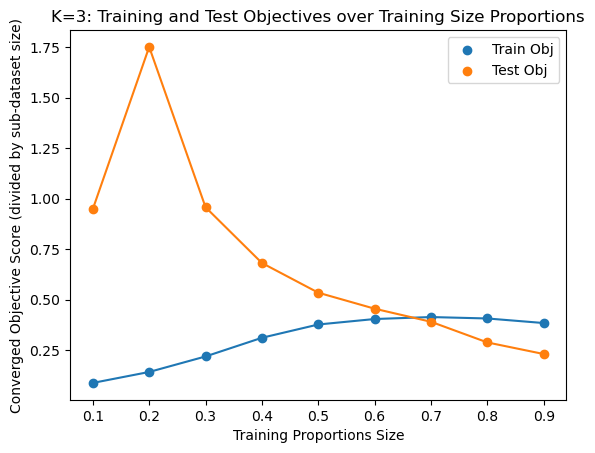

In [17]:
# make the plot
make_train_test_obj_plot(train_prop_list_k3, train_final_obj_list_k3, test_obj_list_k3, k)

## Training and Testing for K=9

In [20]:
# run k-means to get train set and test set final objectives
k = 9
train_prop_list_k9, train_final_obj_list_k9, test_obj_list_k9 = run_train_test_over_props(covid_norm_pred_df_nonan, k, 10, 10)

Train Prop:0.1; train obj: 4.290799118466577; test obj: 533.6211880001104
Train Prop:0.2; train obj: 11.202532613517512; test obj: 457.55918497673764
Train Prop:0.3; train obj: 19.144626588349876; test obj: 317.17719387064915
Train Prop:0.4; train obj: 28.918468003216592; test obj: 216.07744879824895
Train Prop:0.5; train obj: 44.744797564624925; test obj: 121.44795065433506
Train Prop:0.6; train obj: 61.39663007214418; test obj: 86.96958470491607
Train Prop:0.7; train obj: 75.45614690554707; test obj: 57.755572323435274
Train Prop:0.8; train obj: 89.58145079790863; test obj: 35.665721965138125
Train Prop:0.9; train obj: 112.32361176117752; test obj: 13.257282477534378


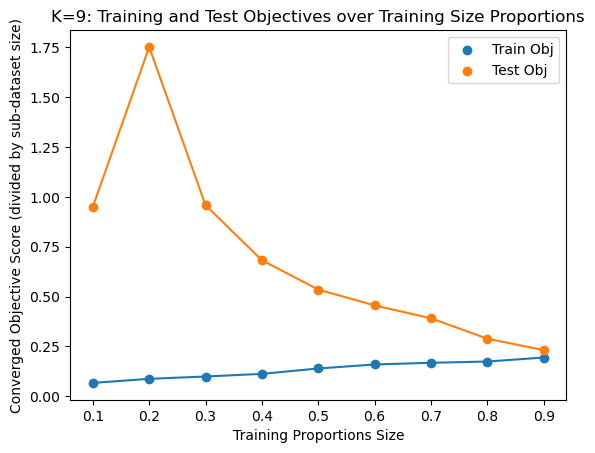

In [21]:
# make the plot
make_train_test_obj_plot(train_prop_list_k9, train_final_obj_list_k9, test_obj_list_k3, 9)